Species Classification

0-funestus 1-gambiae 2-Anopheles_other 3-culex 4-All other

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import math
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Train and test 

In [3]:
train_data = torch.load("/content/drive/MyDrive/CBID/EfficientNet/train_whole_data_fold2.pt")
train_label = torch.load("/content/drive/MyDrive/CBID/EfficientNet/train_whole_label_fold2.pt")
test_data = torch.load("/content/drive/MyDrive/CBID/EfficientNet/test_whole_data.pt")
test_label = torch.load("/content/drive/MyDrive/CBID/EfficientNet/test_whole_label.pt")

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print ("running on the GPU")
else:
    device = torch.device("cpu")
    print ("running on the cpu")

running on the GPU


In [5]:
from torch.utils.data import Dataset


class VectorCamDataset(Dataset):
    
    
    def __init__(self, data, labels, transform=None):
        'Initialization'
        self.labels = labels
        self.data = data
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        
        'Generates one sample of data'

        # Load data and get label
        x = self.data[index]
        y = self.labels[index]
        if self.transform:
            x = self.transform(x)

        return x, y

In [6]:
from torchvision import transforms
invTrans = transforms.Compose([ 
                                transforms.RandomHorizontalFlip(p=0.25),
                                transforms.RandomVerticalFlip(p=0.25)
                                #transforms.Normalize(mean = [ 0.5150, 0.7373, 1.1327 ],
                                #                     std = [ 0.5055, 0.4621, 0.4949 ]),
    
                               ])

In [7]:
train_dataset=VectorCamDataset(train_data,train_label,transform=invTrans)
test_dataset=VectorCamDataset(test_data,test_label)

In [8]:
x, y = train_dataset[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


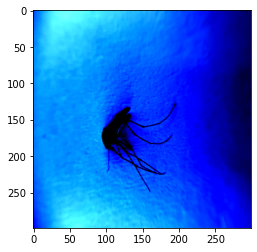

In [9]:
plt.imshow(torch.permute(x, (1, 2, 0)))

In [10]:
from torch.utils.data import DataLoader,WeightedRandomSampler

target_list = torch.tensor(train_dataset.labels)
class_count = np.array([len(np.where(train_dataset.labels == t)[0]) for t in np.unique(train_dataset.labels)])
print(class_count)
class_weights = 1./torch.tensor(class_count, dtype=torch.float)
print(class_weights)
class_weights_all = class_weights[target_list]
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
    )

[1285  466  444  894  325]
tensor([0.0008, 0.0021, 0.0023, 0.0011, 0.0031])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset,sampler=weighted_sampler, batch_size = 32)
test_dataloader = DataLoader(test_dataset,batch_size=32, shuffle=False)

In [12]:
for i, (data, target) in enumerate(train_dataloader):
    print("batch index {}, 0/1: {}/{}/{}/{}/{}".format(
        i,
        len(np.where(target.numpy() == 0)[0]),
        len(np.where(target.numpy() == 1)[0]),
        len(np.where(target.numpy() == 2)[0]),
        len(np.where(target.numpy() == 3)[0]),
        len(np.where(target.numpy() == 4)[0])))

batch index 0, 0/1: 7/6/7/3/9
batch index 1, 0/1: 4/5/6/9/8
batch index 2, 0/1: 4/7/6/8/7
batch index 3, 0/1: 6/6/6/8/6
batch index 4, 0/1: 4/6/6/8/8
batch index 5, 0/1: 2/9/6/12/3
batch index 6, 0/1: 8/5/4/8/7
batch index 7, 0/1: 10/4/5/7/6
batch index 8, 0/1: 9/6/3/9/5
batch index 9, 0/1: 8/5/5/9/5
batch index 10, 0/1: 4/6/8/8/6
batch index 11, 0/1: 6/7/6/8/5
batch index 12, 0/1: 4/9/7/8/4
batch index 13, 0/1: 9/4/5/8/6
batch index 14, 0/1: 3/11/10/4/4
batch index 15, 0/1: 3/8/5/7/9
batch index 16, 0/1: 8/10/7/5/2
batch index 17, 0/1: 4/7/8/6/7
batch index 18, 0/1: 7/8/6/4/7
batch index 19, 0/1: 11/3/2/7/9
batch index 20, 0/1: 3/7/11/6/5
batch index 21, 0/1: 10/5/8/6/3
batch index 22, 0/1: 5/7/7/6/7
batch index 23, 0/1: 3/8/6/7/8
batch index 24, 0/1: 9/4/8/8/3
batch index 25, 0/1: 4/6/7/11/4
batch index 26, 0/1: 7/8/5/6/6
batch index 27, 0/1: 6/4/8/7/7
batch index 28, 0/1: 5/7/5/9/6
batch index 29, 0/1: 5/8/8/6/5
batch index 30, 0/1: 5/8/5/5/9
batch index 31, 0/1: 10/4/5/7/6
batch in

In [13]:
from torchvision import models
model = models.efficientnet_b1(pretrained=False)
model.fc = nn.Linear(2048, 5)
#model.AuxLogits.fc = nn.Linear(768, 5)
#model.load_state_dict(torch.load('/home/shrutihegde/Desktop/EfficientNet/Species_EfficientNet_with_augmentation3.pt'))
model = model.to(device)

In [15]:
EPOCHS = 20
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(),lr = 0.001, weight_decay = 1e-5)
optimizer = optim.SGD(model.parameters(),lr=1e-4, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=0.0001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.15)

In [16]:
def focal_loss(inputs, targets, reduction="mean"):
    CE_loss = F.cross_entropy(inputs, targets, reduction=reduction)
    pt = torch.exp(-CE_loss)  # prevents nans when probability 0
    F_loss = 0.25 * (1 - pt) ** 5 * CE_loss
    return F_loss.mean()

In [17]:
def train(model):
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []

    for epoch in range (EPOCHS+1):
        print(epoch)
        correct = 0
        total = 0
        train_ave_loss = 0
        model.train()
        for batch_X, batch_Y in train_dataloader:
            
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)

            # zero gradient
            optimizer.zero_grad()
            # pass through
            outputs = model(batch_X)

            # compute loss and back propagate
            loss = criterion(outputs, batch_Y)
            #loss2 = criterion(aux_outputs, batch_Y)
            #loss = loss1 + 0.4 * loss2
            
            loss.backward()
            # optimize
            optimizer.step()
            
            train_ave_loss += loss.data.item()
            _, predicted = outputs.max(1)
            total += batch_Y.size(0)
            correct += predicted.eq(batch_Y).sum().item()
            
        
        train_loss.append(train_ave_loss/len(train_dataloader))
        train_acc.append(100.*correct/total)
        print(f"Epoch: {epoch},Train Loss: {train_ave_loss/len(train_dataloader)} | Train Acc: {100.*correct/total} ({correct}/{total})")
    
        if epoch % 1 == 0:
        
            model.eval()
            valid_correct = 0
            valid_total = 0
            valid_ave_loss = 0
            with torch.no_grad():

                for valid_batch_X, valid_batch_Y in test_dataloader:
                    
                    valid_batch_X = valid_batch_X.to(device)
                    valid_batch_Y = valid_batch_Y.to(device)
            
                    valid_outputs = model(valid_batch_X)
                    loss = criterion(valid_outputs, valid_batch_Y)
                    valid_ave_loss += loss.data.item()
        
                    _, predicted = valid_outputs.max(1)

                    valid_correct += predicted.eq(valid_batch_Y).sum().item()
                    valid_total += valid_batch_Y.size(0)
                    
            valid_loss.append(valid_ave_loss/len(test_dataloader))
            valid_acc.append(100.*valid_correct/valid_total)
    
            print(f"Validation Loss: {valid_ave_loss/len(test_dataloader)} | Validation Acc: {100.*valid_correct/valid_total} ({valid_correct}/{valid_total})")
            #torch.save(model.state_dict(), \
            #   'drive/MyDrive/pretrain_data_path/pretrain_Inception{}.pt'.format(str(epoch//1+2)))
        
        #scheduler.step()
        
    return train_loss, valid_loss, train_acc, valid_acc

        
def test(model):
    correct = 0 
    total = 0
    model.eval()
    out = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            #loss = criterion(outputs, test_y[i].to(device).long())
            _, predicted = outputs.max(1)
            out.append(predicted.cpu().detach().numpy())

            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    print("Accuracy:", round(correct/total, 3))
    return out

In [18]:
train_loss, valid_loss, train_acc, valid_acc = train(model)

0
Epoch: 0,Train Loss: 6.546259068997107 | Train Acc: 14.997070884592853 (512/3414)
Validation Loss: 6.642184416453044 | Validation Acc: 14.395393474088293 (150/1042)
1
Epoch: 1,Train Loss: 5.703972437671411 | Train Acc: 31.487990626830697 (1075/3414)
Validation Loss: 6.056914676319469 | Validation Acc: 50.8637236084453 (530/1042)
2
Epoch: 2,Train Loss: 4.931057181313773 | Train Acc: 31.75161101347393 (1084/3414)
Validation Loss: 5.261467702461012 | Validation Acc: 52.20729366602687 (544/1042)
3
Epoch: 3,Train Loss: 4.108855726562928 | Train Acc: 34.387814879906266 (1174/3414)
Validation Loss: 4.176152301557137 | Validation Acc: 54.60652591170825 (569/1042)
4
Epoch: 4,Train Loss: 3.360842352715608 | Train Acc: 36.438195664909195 (1244/3414)
Validation Loss: 3.3924541256644507 | Validation Acc: 44.72168905950096 (466/1042)
5
Epoch: 5,Train Loss: 2.7070941546252953 | Train Acc: 40.27533684827182 (1375/3414)
Validation Loss: 2.7417651902545583 | Validation Acc: 36.756238003838774 (383/104

In [19]:
 out = test(model)

Accuracy: 0.746


In [20]:
out = np.concatenate(out).ravel()

In [21]:
out

array([3, 2, 2, ..., 0, 0, 0])

              precision    recall  f1-score   support

           0       0.78      0.97      0.87       410
           1       0.53      0.50      0.51       159
           2       0.69      0.43      0.53       151
           3       0.85      0.73      0.78       252
           4       0.69      0.76      0.72        70

    accuracy                           0.75      1042
   macro avg       0.71      0.68      0.68      1042
weighted avg       0.74      0.75      0.73      1042



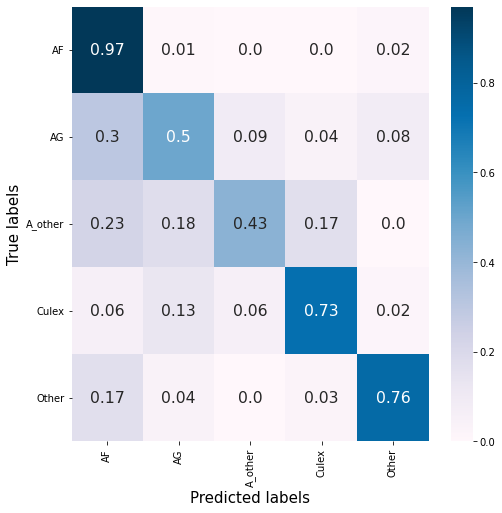

In [22]:
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
species_all = ["AF",
        "AG",
        "A_other",
        "Culex",
        "Other"]
# print classification report
print(classification_report(test_label, out))

# make confusion matrix
conf_mat = confusion_matrix(test_label, out)
conf_mat = conf_mat / np.expand_dims(conf_mat.astype(np.float64).sum(axis=1),1)
conf_mat = np.round(conf_mat, decimals=2)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()
hm = sn.heatmap(conf_mat, annot=True, ax = ax, cmap="PuBu", fmt='.2', annot_kws={"size": 35 / np.sqrt(len(conf_mat))})
ax.set_yticklabels(hm.get_yticklabels(), rotation=90)
ax.set_xlabel('Predicted labels', fontsize = 15);ax.set_ylabel('True labels', fontsize = 15); 
ax.xaxis.set_ticklabels(species_all); ax.yaxis.set_ticklabels(species_all)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.savefig('/content/drive/MyDrive/CBID/EfficientNet/Species_EfficientNet_with_augmentation3.jpg')
plt.show();


In [23]:
torch.save(model.state_dict(), \
               '/content/drive/MyDrive/CBID/EfficientNet/Species_EfficientNet_with_augmentation3.pt')